In [1]:
import os
import sys
import time

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import cv2
from PIL import Image
import matplotlib.pyplot as plt

from yolov3.models import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *

import kcftracker
from siamfc import *
from my_utils import *

from A3C import *
from utils_A3C import *
from pointnet import *

In [2]:
image_folder = "yolov3/data/samples"
model_def = "yolov3/cfg/yolov3-spp.cfg"
weights_path = "yolov3/weights/weights/yolov3-spp.weights"
class_path = "yolov3/data/coco.names"

conf_thres = 0.5
nms_thres = 0.5
batch_size = 1
img_size = 416

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up model
model = Darknet(model_def, img_size=img_size).to(device)
_ = load_darknet_weights(model, weights_path)
model.eval()

dataloader = LoadImages(image_folder, img_size=img_size)
classes = load_classes(class_path)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]

image 1/11 yolov3/data/samples/bus.jpg: 3 persons, 1 buss, 1 handbags, 

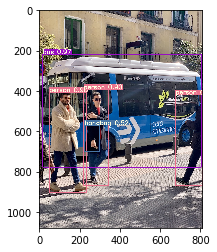

image 2/11 yolov3/data/samples/dog.jpg: 1 bicycles, 1 trucks, 1 dogs, 

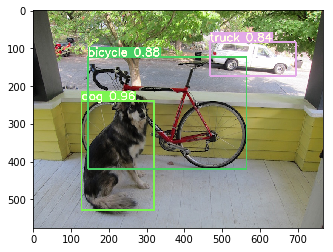

image 3/11 yolov3/data/samples/eagle.jpg: 1 birds, 

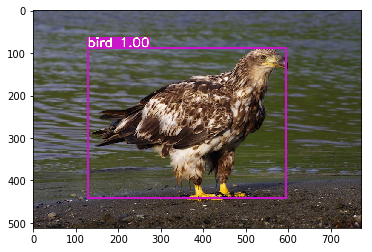

image 4/11 yolov3/data/samples/field.jpg: 1 persons, 1 dogs, 1 horses, 

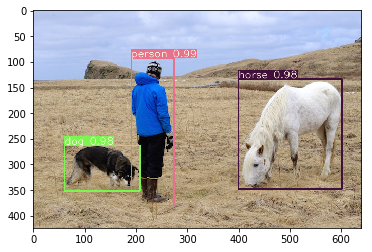

image 5/11 yolov3/data/samples/giraffe.jpg: 1 zebras, 1 giraffes, 

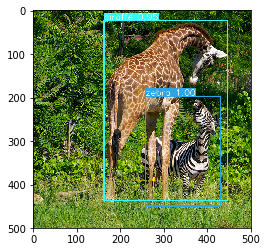

image 6/11 yolov3/data/samples/herd_of_horses.jpg: 4 horses, 

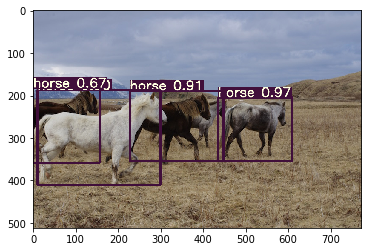

image 7/11 yolov3/data/samples/messi.jpg: 3 persons, 

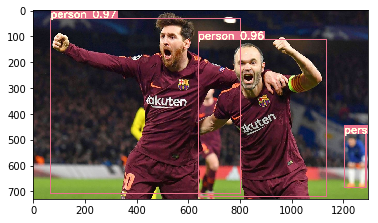

image 8/11 yolov3/data/samples/person.jpg: 1 persons, 1 dogs, 

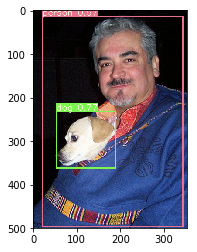

image 9/11 yolov3/data/samples/room.jpg: 3 chairs, 1 clocks, 

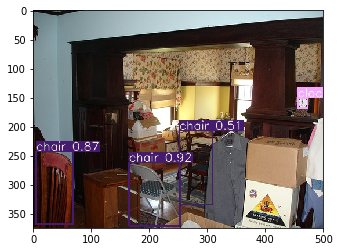

image 10/11 yolov3/data/samples/street.jpg: 8 cars, 1 trucks, 1 traffic lights, 1 parking meters, 

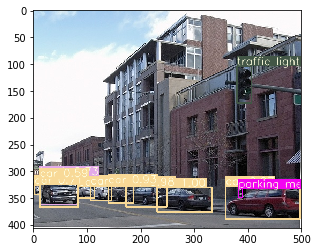

image 11/11 yolov3/data/samples/zidane.jpg: 2 persons, 1 ties, 

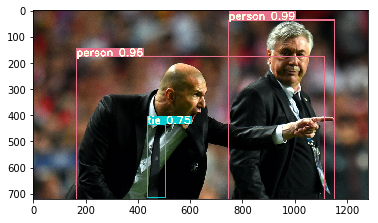

In [3]:
for i, (path, img, im0, vid_cap) in enumerate(dataloader):
    t = time.time()

    # Get detections
    img = torch.from_numpy(img).unsqueeze(0).to(device)
    pred, _ = model(img)
    det = non_max_suppression(pred, conf_thres, nms_thres)[0]

    if det is not None and len(det) > 0:
        # Rescale boxes from 416 to true image size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

        # Print results to screen
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()
            print('%g %ss' % (n, classes[int(c)]), end=', ')

        # Draw bounding boxes and labels of detections
        for x1, y1, x2, y2, conf, *cls_conf, cls in det:
            # Add bbox to the image
            label = '%s %.2f' % (classes[int(cls)], conf)
            plot_one_box([x1, y1, x2, y2], im0, label=label, color=colors[int(cls)])
            
        plt.imshow(im0[:,:,::-1])
        plt.show()

In [4]:
class_ids = ['n02691156', 'n02419796', 'n02131653', 'n02834778',
             'n01503061', 'n02924116', 'n02958343', 'n02402425',
             'n02084071', 'n02121808', 'n02503517', 'n02118333',
             'n02510455', 'n02342885', 'n02374451', 'n02129165',
             'n01674464', 'n02484322', 'n03790512', 'n02324045',
             'n02509815', 'n02411705', 'n01726692', 'n02355227',
             'n02129604', 'n04468005', 'n01662784', 'n04530566',
             'n02062744', 'n02391049']

class_names = ['airplane', 'antelope', 'bear', 'bicycle',
               'bird', 'bus', 'car', 'cow',
               'dog', 'cat', 'elephant', 'fox',
               'giant_panda', 'hamster', 'horse', 'lion',
               'lizard', 'monkey', 'motorcycle', 'rabbit',
               'red_panda', 'sheep', 'snake', 'squirrel',
               'tiger', 'train', 'turtle', 'watercraft',
               'whale', 'zebra']

id2idx = {id:idx for idx, id in enumerate(class_ids)}

valid_classes = [0,2,3,4,5,6,7,8,9,10,14,18,21,25]

coco_classes = [4, None, 21, 1,
               14, 5, 2, 19,
               16, 15, 20, None,
               None, None, 17, None,
               None, None, 3, None,
               None, 18, None, None,
               None, 6, None, None,
               None, None]

coco2imgnet = {i:None for i in range(80)}
for idx, cls in enumerate(coco_classes):
    if cls:
        coco2imgnet[cls] = idx

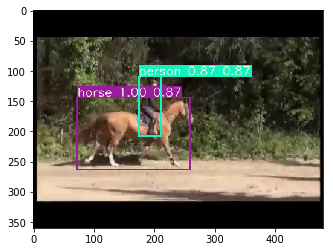

100
number of objects = 2
avg fps = 74.79611777911933
avg detection interval = 5.8076923076923075


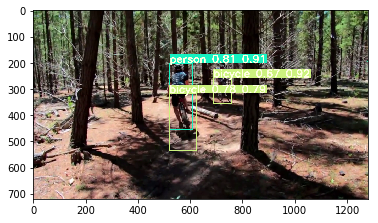

100
number of objects = 4
avg fps = 33.8357806423559
avg detection interval = 5.892857142857143


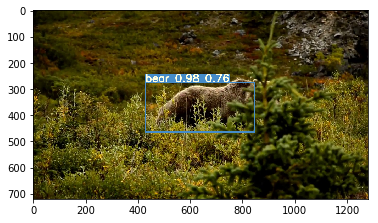

100


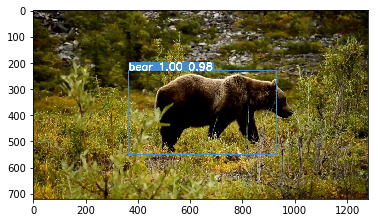

200


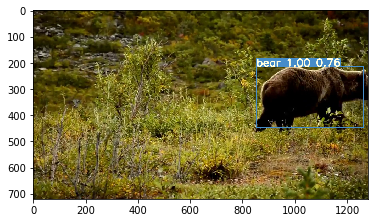

300


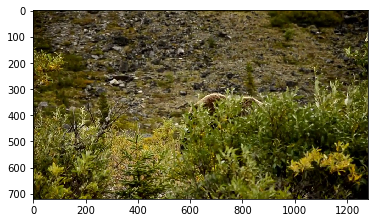

400
number of objects = 0
avg fps = 62.04086832850459
avg detection interval = 6.0


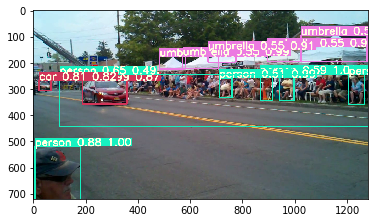

100


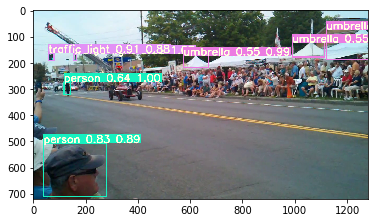

200


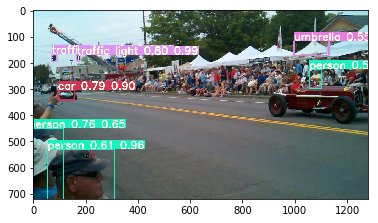

300


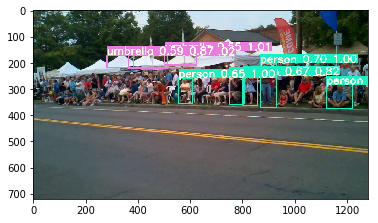

400


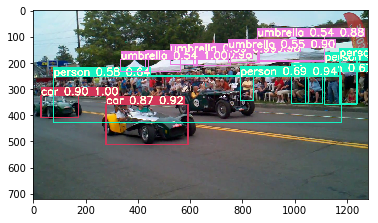

500


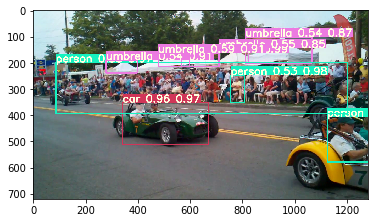

600


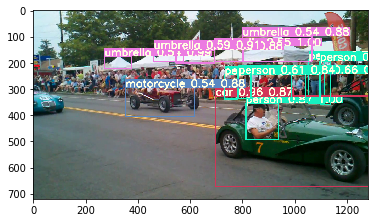

700


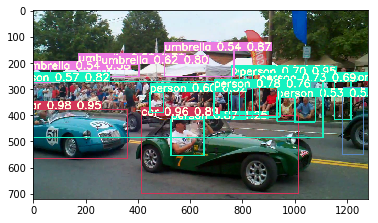

800


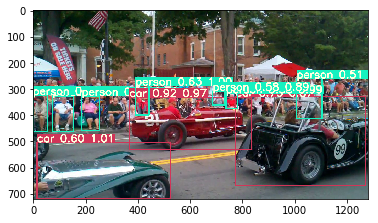

900
number of objects = 10
avg fps = 14.229616069664948
avg detection interval = 6.0


In [43]:
data_dir = "data/ILSVRC2015/Data/VID/snippets/"

videos = ['horse', 'bicycle', 'bear', 'cars']

for video in videos:

    if video == 'street':
        video_path = data_dir + "test/ILSVRC2015_test_00145000.mp4"
    elif video == 'horse':
        video_path = data_dir + "test/ILSVRC2015_test_00254002.mp4"
    elif video == 'tiger':
        video_path = data_dir + "test/ILSVRC2015_test_00021002.mp4"
    elif video == 'bicycle':
        video_path = data_dir + "val/ILSVRC2015_val_00124001.mp4"
    elif video == 'men':
        video_path = data_dir + "val/ILSVRC2015_val_00073000.mp4"
    elif video == 'bear':
        video_path = data_dir + "val/ILSVRC2015_val_00161000.mp4"
    elif video == 'cars':
        video_path = data_dir + "val/ILSVRC2015_val_00107000.mp4"
    elif video == 'airplanes':
        video_path = data_dir + "train/ILSVRC2015_VID_train_0003/ILSVRC2015_train_01000001.mp4"
        
    vid             = cv2.VideoCapture(video_path)    
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))


    iou_thres = 0.5
    conf_thres = 0.5
    max_interval = 15
    tracking_threshold = 0.5

    output_path = 'videos/yolov3_{}_kcf_policy.avi'.format(video)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc('M','J','P','G'), video_fps, video_size)


    boxes = []
    trackers = []

    frame_i = 0
    detect_frames = 0
    total_inference_time = 0

    while True:
        _, frame = vid.read()    
        if frame is None:
            break

        prev_time = time.time()

        # Scheduling
        if frame_i == 0:
            boxes = []
            trackers = []
            keyframe = True
            detect = True
            detect_interval = max_interval
            
        elif last_detect < detect_interval:
            keyframe = False
            detect = keyframe
            
        else:
            keyframe = False
            detect = True
        
        
        # Tracking
        track = True
        if track:
            for i in range(len(boxes)):
                peak_value, box = trackers[i].update(frame[:,:,::-1])
                x1, y1, x2, y2 = from_tracking_box(box)
                boxes[i][-2] = peak_value
                boxes[i][:4] = np.array([x1, y1, x2, y2])
                if peak_value < tracking_threshold:
                    keyframe = True
                    detect = True
        
        
        if keyframe:
            detect_interval = 2
        elif detect:
            detect_interval = detect_interval*2 if detect_interval*2 < max_interval else max_interval

        keyframe = False
        detect = frame_i % 6 == 0
        # detect_interval = max_interval
        
        frame_i += 1
        detect_frames += detect
        last_detect = 1 if detect else last_detect + 1
            
            
        # Detection
        if detect:
            img, *_ = letterbox(frame, new_shape=img_size)
            img = img[:, :, ::-1].transpose(2, 0, 1)
            img = np.ascontiguousarray(img, dtype=np.float32)
            img = torch.from_numpy(img / 255.0).unsqueeze(0).cuda()

            boxes_new = [] 
            with torch.no_grad():
                pred, _ = model(img)
                if track:
                    detections = my_nms_mergecls(pred, 0.1, iou_thres)[0]
                else:
                    detections = my_nms(pred, conf_thres, iou_thres)[0]
                             
                if detections is not None:   
                    detections[:,:4] = scale_coords(img.shape[2:], detections[:,:4], frame.shape).round()
                    boxes_new = [det.data.cpu().numpy() for det in detections]
                            
            boxes = update_bbox(boxes, boxes_new, conf_thres, merge=track)
                
            if track:
                trackers = []
                for box in boxes:
                    trackers.append(kcftracker.KCFTracker(False, True, True))
                    trackers[-1].init(to_tracking_box(box[:4]), frame[:,:,::-1])
                    #trackers.append(TrackerSiamFC(net_path='model.pth'))
                    #trackers[-1].init(frame[:,:,::-1], to_tracking_box(box[:4]))


        # Compute inference time
        inference_time = time.time() - prev_time
        if frame_i != 0:
            total_inference_time += inference_time


        # Write frame to output video
        for x1, y1, x2, y2, conf, *cls_conf, track_score, cls in boxes:
            label = '%s %.2f %.2f' % (classes[int(cls)], conf, track_score)
            plot_one_box([x1, y1, x2, y2], frame, label=label, color=colors[int(cls)])

        if keyframe:
            plot_one_box([3, 3, frame.shape[1]-3, frame.shape[0]-3], frame, label='', color=[0,0,255])

        out.write(frame)


        # Plot results
        if frame_i % 100 == 0:
            result = Image.fromarray(frame[:,:,::-1])
            fig, ax = plt.subplots(1)
            ax.imshow(result)
            plt.show()
            print(frame_i)


    print('number of objects =', len(boxes))
    print('avg fps =', (frame_i-1) / total_inference_time)
    print('avg detection interval =', frame_i / detect_frames)

In [ ]:
data_dir = 'data/ILSVRC2015/Data/VID/val/'
val_file = 'data/ILSVRC2015/ImageSets/VID/my_val.txt'

iou_thres = 0.5
conf_thres = 0.5
tracking_threshold = 0.5
max_interval = 25

total_frames = 0
detect_frames = 0


N_S = 20
N_A = 2
gnet = Net(N_S, N_A)
checkpoint = torch.load('A3C.pth')
gnet.load_state_dict(checkpoint)
gnet.to(device)
gnet.eval()


with open(val_file, 'r') as f:
    img_list = f.read().splitlines()
    
    tp_list = []
    conf_list = []
    cls_pred_list = []
    cls_gt_list = []
    
    for idx, img_id in enumerate(img_list):
        frame_i = int(img_id.split(' ')[0].split('/')[-1])
        img = data_dir + img_id.split(' ')[0] + '.JPEG'
        label = img.replace('Data', 'Annotations').replace('.JPEG', '.xml')
        
        frame = cv2.imread(img)
        boxes_gt = parse_bbox(label, id2idx, valid_classes)
            
        # Scheduling
        if frame_i == 0:
            boxes = []
            trackers = []
            keyframe = True
            detect = True
            last_detect = 1
            detect_interval = max_interval
            
        elif last_detect < detect_interval:
            img0 = data_dir + img_list[idx-1].split(' ')[0] + '.JPEG'
            label0 = img0.replace('Data', 'Annotations').replace('.JPEG', '.xml')
            boxes0 = parse_bbox(label0, id2idx)
            keyframe = False # len(boxes_gt) != len(boxes0)
            detect = keyframe
            
        else:
            keyframe = False
            detect = True
            
        
        # Tracking
        track = True
        if track:
            for i in range(len(boxes)):
                score, box = trackers[i].update(frame[:,:,::-1])
                x1, y1, x2, y2 = from_tracking_box(box)
                boxes[i][:4] = np.array([x1, y1, x2, y2])
                boxes[i][8] = score
                boxes[i][9] = (boxes[i][9]*boxes[i][10] + score) / (boxes[i][10] + 1)
                boxes[i][10] += 1
                if score < tracking_threshold:
                    keyframe = True
                    detect = True
        
        
        if keyframe:
            detect_interval = 2
        elif detect:
            detect_interval = detect_interval*2 if detect_interval*2 < max_interval else max_interval

        
        #state = boxes_to_state(boxes, (20,10), last_detect, valid_classes)
        #logits, _ = gnet.forward(state)
        #prob = F.softmax(logits, dim=1).data
        #detect = prob[0,1] > 0.8
        #detect = True if (frame_i == 0) else detect
        detect = frame_i % 2 == 0
        # detect_interval = max_interval
        
        total_frames += 1
        detect_frames += detect
        last_detect = 1 if detect else last_detect + 1
            
            
        # Detection
        if detect:
            img, *_ = letterbox(frame, new_shape=img_size)
            img = img[:, :, ::-1].transpose(2, 0, 1)
            img = np.ascontiguousarray(img, dtype=np.float32)
            img = torch.from_numpy(img / 255.0).unsqueeze(0).cuda()

            boxes_new = [] 
            with torch.no_grad():
                pred, _ = model(img)
                if track:
                    detections = my_nms_mergecls(pred, 0.1, iou_thres)[0]
                else:
                    detections = my_nms(pred, conf_thres, iou_thres)[0]
                             
                if detections is not None:   
                    detections[:,:4] = scale_coords(img.shape[2:], detections[:,:4], frame.shape).round()
                    boxes_new = [det.data.cpu().numpy() for det in detections]
            
            if track:
                boxes = update_bbox(boxes, boxes_new, iou_thres, conf_thres, frame.shape, coco2imgnet, valid_classes)
            else:
                boxes = update_bbox([], boxes_new, iou_thres, conf_thres, frame.shape, coco2imgnet, valid_classes)
                
            if track:
                trackers = []
                for box in boxes:
                    trackers.append(kcftracker.KCFTracker(False, True, True))
                    trackers[-1].init(to_tracking_box(box[:4]), frame[:,:,::-1])
                    #trackers.append(TrackerSiamFC(net_path='model.pth'))
                    #trackers[-1].init(frame[:,:,::-1], to_tracking_box(box[:4]))
    
                
        # Evaluation
        tp_list += get_tp(boxes, boxes_gt, iou_thres)
        conf_list += [b[4] for b in boxes]
        cls_pred_list += [b[-1] for b in boxes]
        cls_gt_list += [b[-1] for b in boxes_gt]

        if frame_i == 0:
            print(img_id)
            
            mAP = compute_mAP(tp_list, conf_list, cls_pred_list, cls_gt_list)
            print(mAP)
            
            # Ground truth boxes
            for *xyxy, cls in boxes_gt:
                label = '%s' % (class_names[int(cls)])
                plot_one_box(xyxy, frame, label=label, color=colors[(int(cls)+1) % len(colors)])

            # Predicted boxes
            for x1, y1, x2, y2, conf, conf_avg, n_detect, track, track_min, n_track, *cls_conf, cls in boxes:
                label = '%s %.2f' % (class_names[int(cls)], conf)
                plot_one_box([x1, y1, x2, y2], frame, label=label, color=colors[int(cls)])
              
            result = Image.fromarray(frame[:,:,::-1])
            fig, ax = plt.subplots(1)
            ax.imshow(result)
            plt.show()
            
print(np.array(mAP).mean())
print(total_frames / detect_frames)

In [7]:
data_dir = 'data/ILSVRC2015/Data/VID/val/'
val_list = 'data/ILSVRC2015/ImageSets/VID/val.txt'

invalid_video = set()
with open(val_list, 'r') as f:
    img_list = f.read().splitlines()
    
    for img_id in img_list:
        video_i = img_id.split('/')[0]
        frame_i = int(img_id.split(' ')[0].split('/')[-1])
        
        img = data_dir + img_id.split(' ')[0] + '.JPEG'
        label = img.replace('Data', 'Annotations').replace('.JPEG', '.xml')
        boxes_gt = parse_bbox(label, id2idx)
        
        if any(b[-1] not in valid_classes for b in boxes_gt):
            invalid_video.add(video_i)
            
            
output_file = val_list.replace('val.txt', 'my_val.txt')
with open(output_file, 'w') as f:
    for img_id in img_list:
        video_i = img_id.split('/')[0]
        if not video_i in invalid_video:
            f.write(img_id + '\n')

In [5]:
data_dir = 'data/ILSVRC2015/Data/VID/train/'
train_list = 'data/ILSVRC2015/ImageSets/VID/train_{}.txt'

valid_video = set()
invalid_video = set()

for i in range(30):
    train_file = train_list.format(i+1)
    
    with open(train_file, 'r') as f:
        vid_list = f.read().splitlines()

        for vid in vid_list:
            vid_id = vid.split(' ')[0]
            img_list = sorted([data_dir + vid_id + '/' + f for f in os.listdir(data_dir + vid_id) if f[-5:] == '.JPEG'])

            for img in img_list:
                label = img.replace('Data', 'Annotations').replace('.JPEG', '.xml')
                boxes_gt = parse_bbox(label, id2idx)

                if any(b[-1] not in valid_classes for b in boxes_gt):
                    invalid_video.add(vid_id)
                    
            if vid_id not in invalid_video:
                valid_video.add(vid_id)
        
            
output_file = 'data/ILSVRC2015/ImageSets/VID/my_train.txt'
with open(output_file, 'w') as f:
    for vid in valid_video:
        f.write(vid + ' 1\n')

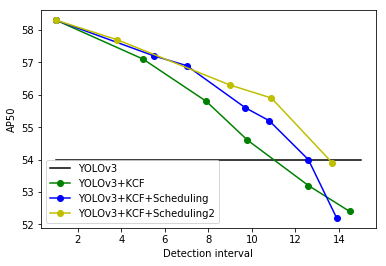

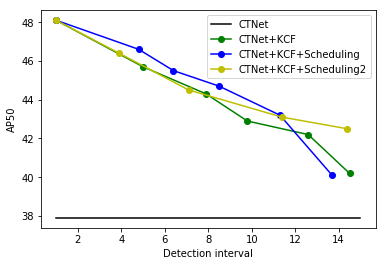

In [48]:
t_yolov3 = [1, 5.0, 7.9, 9.8, 12.6, 14.5]
mAP_yolov3 = [58.3, 57.1, 55.8, 54.6, 53.2, 52.4]

t_yolov3_scheduling = [1, 5.5, 7.0, 9.7, 10.8, 12.6, 13.9]
mAP_yolov3_scheduling = [58.3, 57.2, 56.9, 55.6, 55.2, 54.0, 52.2]

t_yolov3_scheduling2 = [1, 3.8, 9.0, 10.9, 13.7]
mAP_yolov3_scheduling2 = [58.3, 57.7, 56.3, 55.9, 53.9]


t_ctnet = [1, 5.0, 7.9, 9.8, 12.6, 14.5]
mAP_ctnet = [48.1, 45.7, 44.3, 42.9, 42.2, 40.2]

t_ctnet_scheduling = [1, 4.8, 6.4, 8.5, 11.3, 13.7]
mAP_ctnet_scheduling = [48.1, 46.6, 45.5, 44.7, 43.2, 40.1]

t_ctnet_scheduling2 = [1, 3.9, 7.1, 11.4, 14.4]
mAP_ctnet_scheduling2 = [48.1, 46.4, 44.5, 43.1, 42.5]


plt.figure()
plt.plot(range(1,16), [54.0]*15, 'k-', label='YOLOv3')
plt.plot(t_yolov3, mAP_yolov3, 'og-', label='YOLOv3+KCF')
plt.plot(t_yolov3_scheduling, mAP_yolov3_scheduling, 'ob-', label='YOLOv3+KCF+Scheduling')
plt.plot(t_yolov3_scheduling2, mAP_yolov3_scheduling2, 'oy-', label='YOLOv3+KCF+Scheduling2')
plt.legend()
plt.xlabel('Detection interval')
plt.ylabel('AP50')
plt.savefig('YOLOv3.png')
plt.show()

plt.figure()
plt.plot(range(1,16), [37.9]*15, 'k-', label='CTNet')
plt.plot(t_ctnet, mAP_ctnet, 'og-', label='CTNet+KCF')
plt.plot(t_ctnet_scheduling, mAP_ctnet_scheduling, 'ob-', label='CTNet+KCF+Scheduling')
plt.plot(t_ctnet_scheduling2, mAP_ctnet_scheduling2, 'oy-', label='CTNet+KCF+Scheduling2')
plt.legend()
plt.xlabel('Detection interval')
plt.ylabel('AP50')
plt.savefig('CTNet.png')
plt.show()

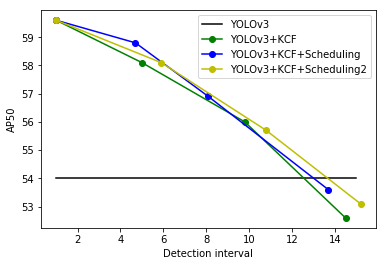

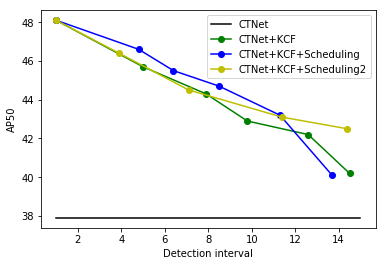

In [15]:
t_yolov3 = [1, 5.0, 9.8, 14.5]
mAP_yolov3 = [59.6, 58.1, 56.0, 52.6]

t_yolov3_scheduling = [1, 4.7, 8.1, 13.7]
mAP_yolov3_scheduling = [59.6, 58.8, 56.9, 53.6]

t_yolov3_scheduling2 = [1, 5.9, 10.8, 15.2]
mAP_yolov3_scheduling2 = [59.6, 58.1, 55.7, 53.1]

t_yolov3_a3c = [1, 2]
mAP_yolov3_a3c = [59.6, 59.5]


t_ctnet = [1, 5.0, 7.9, 9.8, 12.6, 14.5]
mAP_ctnet = [48.1, 45.7, 44.3, 42.9, 42.2, 40.2]

t_ctnet_scheduling = [1, 4.8, 6.4, 8.5, 11.3, 13.7]
mAP_ctnet_scheduling = [48.1, 46.6, 45.5, 44.7, 43.2, 40.1]

t_ctnet_scheduling2 = [1, 3.9, 7.1, 11.4, 14.4]
mAP_ctnet_scheduling2 = [48.1, 46.4, 44.5, 43.1, 42.5]


plt.figure()
plt.plot(range(1,16), [54.0]*15, 'k-', label='YOLOv3')
plt.plot(t_yolov3, mAP_yolov3, 'og-', label='YOLOv3+KCF')
plt.plot(t_yolov3_scheduling, mAP_yolov3_scheduling, 'ob-', label='YOLOv3+KCF+Scheduling')
plt.plot(t_yolov3_scheduling2, mAP_yolov3_scheduling2, 'oy-', label='YOLOv3+KCF+Scheduling2')
plt.legend()
plt.xlabel('Detection interval')
plt.ylabel('AP50')
plt.savefig('YOLOv3.png')
plt.show()

plt.figure()
plt.plot(range(1,16), [37.9]*15, 'k-', label='CTNet')
plt.plot(t_ctnet, mAP_ctnet, 'og-', label='CTNet+KCF')
plt.plot(t_ctnet_scheduling, mAP_ctnet_scheduling, 'ob-', label='CTNet+KCF+Scheduling')
plt.plot(t_ctnet_scheduling2, mAP_ctnet_scheduling2, 'oy-', label='CTNet+KCF+Scheduling2')
plt.legend()
plt.xlabel('Detection interval')
plt.ylabel('AP50')
plt.savefig('CTNet.png')
plt.show()

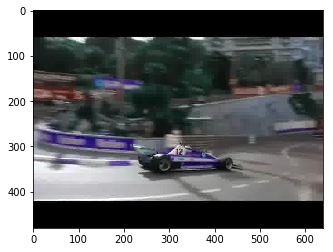

In [8]:
import matplotlib.pyplot as plt
import cv2

im = cv2.imread('data/ILSVRC2015/Data/VID/train/ILSVRC2015_VID_train_0001/ILSVRC2015_train_00301017/000042.JPEG')
plt.imshow(im)
plt.show()

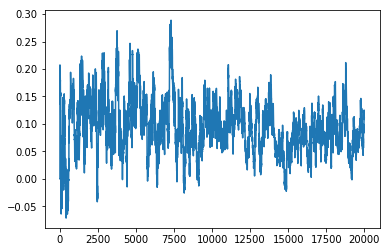

In [31]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.load('rewards_detect2.npy')
plt.figure()
plt.plot(rewards)
plt.show()

In [ ]:
from pointnet import *

sim_data = Variable(torch.rand(1,20,10))
model = PointNetCls(d=20, k=4, feature_transform=False)
out, _, _ = model(sim_data)
print(out.size())

sim_data_64d = Variable(torch.rand(2, 3, 10))
trans = STN3d()
out = trans(sim_data_64d)
print('stn64d', out.size())

In [ ]:
a3c
[73.2 51.7 69.2 11.6 69.2 52.6 53.  20.1 80.7 82.  20.4 55.2 79.2 87.1]
Avg detection interval = 8.358382642998027
0.575134956872942



fixed
1
[78.7 51.3 70.2 13.4 72.3 55.2 55.8 20.9 81.9 84.3 21.7 61.3 83.4 84.1]
Avg detection interval = 1.0
0.595969007299393

3
[77.6 47.6 69.8 12.9 71.  53.9 55.2 20.3 83.5 85.6 21.5 62.4 81.8 81.9]
Avg detection interval = 2.986819847758669
0.5893586518573485

6
[75.  49.7 69.8 11.7 69.7 52.6 51.7 19.3 83.7 82.  20.7 59.3 79.6 85.4]
Avg detection interval = 5.931830907054871
0.5787913194892024

9
[71.1 42.1 66.3 11.5 68.1 49.2 49.9 15.8 81.  83.2 19.1 57.3 77.9 84.2]
Avg detection interval = 8.837747653806048
0.5547354092016621

12
[69.1 50.  66.1 11.8 67.2 48.6 49.  15.8 80.7 77.7 18.4 49.7 81.8 82.6]
Avg detection interval = 11.70958828405637
0.5488666835675722

15
[65.7 40.5 65.3  9.3 66.3 48.  47.2 12.4 76.2 88.1 21.3 43.2 77.1 84.2]
Avg detection interval = 14.537564322469983
0.5319608154138553


heuristic
3
[77.4 50.6 69.7 13.3 70.3 54.1 55.5 20.6 83.5 85.6 22.6 59.4 81.8 80. ]
Avg detection interval = 2.9586678768414436
0.5888152103378141

6
[75.9 51.3 68.2 13.3 71.6 53.6 53.  19.2 81.7 84.3 23.1 58.4 83.3 85. ]
Avg detection interval = 5.502077382498053
0.5868768557245415

9
[73.7 48.4 69.3 10.8 68.7 52.9 54.6 18.9 81.1 78.3 22.  57.  78.6 88. ]
Avg detection interval = 7.894374068554397
0.5728718245417592

12
[71.1 50.7 65.6 11.9 69.  50.6 50.  19.4 82.7 81.2 20.6 52.1 79.4 87. ]
Avg detection interval = 10.216248794599807
0.5651756450956154

15
[69.1 43.  64.5  8.8 66.9 48.  50.4 15.3 79.5 78.4 22.4 50.5 79.3 92.1]
Avg detection interval = 12.43456572769953
0.5487998170015268




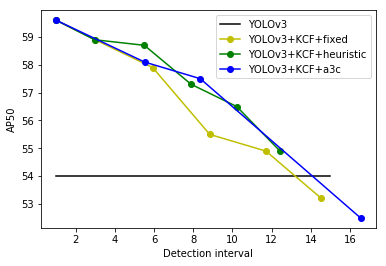

In [30]:
import matplotlib.pyplot as plt

t_yolov3_fixed = [1, 2.99, 5.93, 8.84, 11.71, 14.54]
mAP_yolov3_fixed = [59.6, 58.9, 57.9, 55.5, 54.9, 53.2]

t_yolov3_heuristic = [1, 2.96, 5.50, 7.89, 10.22, 12.43]
mAP_yolov3_heuristic = [59.6, 58.9, 58.7, 57.3, 56.5, 54.9]

t_yolov3_a3c = [1, 5.51, 8.36, 16.54]
mAP_yolov3_a3c = [59.6, 58.1, 57.5, 52.5]


plt.figure()
plt.plot(range(1,16), [54.0]*15, 'k-', label='YOLOv3')
plt.plot(t_yolov3_fixed, mAP_yolov3_fixed, 'oy-', label='YOLOv3+KCF+fixed')
plt.plot(t_yolov3_heuristic, mAP_yolov3_heuristic, 'og-', label='YOLOv3+KCF+heuristic')
plt.plot(t_yolov3_a3c, mAP_yolov3_a3c, 'ob-', label='YOLOv3+KCF+a3c')
plt.legend()
plt.xlabel('Detection interval')
plt.ylabel('AP50')
plt.savefig('YOLOv3.png')
plt.show()